### Imports and setup

In [29]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import statsmodels.formula.api as smf
from psmpy import PsmPy
from scipy.spatial.distance import mahalanobis
from sklearn.linear_model import LinearRegression, LogisticRegression

pd.set_option("display.max_columns", None)

In [2]:
PATH = "../testdata/lalonde.RData"
seed = 1234
num_trees = None

Y = "re78"
treat = "treat"
covar = [
    "age",
    "education",
    "black",
    "hispanic",
    "married",
    "nodegree",
    "re74",
    "re75",
    "u74",
    "u75",
]

raw = pyreadr.read_r(PATH)
# raw.keys()

In [48]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )


In [3]:
# Chat GPT translation from R
# ===========================


def standardized_diff(data, treat, covar):
    treated = data[data[treat] == 1]
    control = data[data[treat] == 0]

    std_diff = []
    for var in covar:
        mean_treated = treated[var].mean()
        mean_control = control[var].mean()
        sd_pooled = np.sqrt((treated[var].var() + control[var].var()) / 2)
        std_diff.append((mean_treated - mean_control) / sd_pooled)

    return np.array(std_diff)


def love_plot(data_pre, data_post, treat, covar, threshold=0.1, title="Love Plot"):
    std_diff_pre = standardized_diff(data_pre, treat, covar)
    std_diff_post = standardized_diff(data_post, treat, covar)

    love_data = pd.DataFrame(
        {
            "Variable": np.tile(covar, 2),
            "Std_Diff": np.concatenate([std_diff_pre, std_diff_post]),
            "Matching": ["Pre-Matching"] * len(covar) + ["Post-Matching"] * len(covar),
        }
    )

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=love_data, x="Variable", y="Std_Diff", hue="Matching", s=100)

    plt.axhline(0, linestyle="--", color="black", linewidth=1)
    plt.axhline(threshold, linestyle="--", color="red", linewidth=1)
    plt.axhline(-threshold, linestyle="--", color="red", linewidth=1)

    plt.title(title)
    plt.xlabel("Covariates")
    plt.ylabel("Standardized Mean Differences")
    plt.xticks(rotation=90)
    plt.gca().invert_yaxis()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

___
## LDW-CPS1

In [4]:
data = raw["ldw_cps"].copy().reset_index(drop=True)
data.reset_index(inplace=True, names="row_idx")

In [5]:
data.groupby(treat)["sample"].count()

treat
0.0    15992
1.0      185
Name: sample, dtype: int64

### Covariate balance

In [6]:
data[data[treat] == 0][covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,33.225238,11.045216,16.0,24.000000,31.000000,42.000000,55.000000
education,12.027514,2.870846,0.0,11.000000,12.000000,13.000000,18.000000
black,0.073537,0.261024,0.0,0.000000,0.000000,0.000000,1.000000
hispanic,0.072036,0.258556,0.0,0.000000,0.000000,0.000000,1.000000
married,0.711731,0.452971,0.0,0.000000,1.000000,1.000000,1.000000
nodegree,0.295835,0.456432,0.0,0.000000,0.000000,1.000000,1.000000
re74,14016.800360,9569.795964,0.0,4403.452393,15123.580078,23584.179688,25862.320312
re75,13650.803522,9270.403408,0.0,4398.823242,14557.110352,22923.736816,25243.550781
u74,0.119622,0.324530,0.0,0.000000,0.000000,0.000000,1.000000
u75,0.109305,0.312031,0.0,0.000000,0.000000,0.000000,1.000000


In [7]:
data[data[treat] == 1][covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,25.816216,7.155019,17.0,20.0,25.0,29.000000,48.000000
education,10.345946,2.010650,4.0,9.0,11.0,12.000000,16.000000
black,0.843243,0.364558,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.059459,0.237124,0.0,0.0,0.0,0.000000,1.000000
married,0.189189,0.392722,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
re74,2095.573693,4886.620354,0.0,0.0,0.0,1291.468018,35040.070312
re75,1532.055313,3219.250879,0.0,0.0,0.0,1817.284058,25142.240234
u74,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
u75,0.600000,0.491227,0.0,0.0,1.0,1.000000,1.000000


### Positivity check

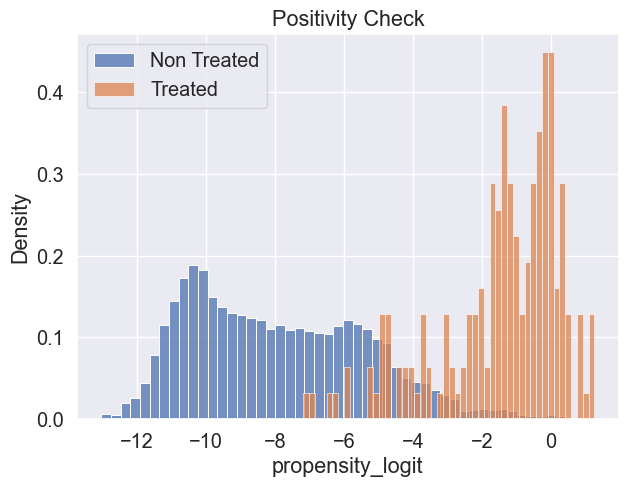

In [8]:
psm = PsmPy(data, treatment=treat, indx="row_idx", exclude=["data_id", Y, "sample"])
psm.logistic_ps(balance=False)

plt.figure(figsize=(7, 5))
sns.histplot(
    psm.predicted_data.query("treat==0")["propensity_logit"],
    kde=False,
    label="Non Treated",
    bins=50,
    stat="density",
)
sns.histplot(
    psm.predicted_data.query("treat==1")["propensity_logit"],
    kde=False,
    label="Treated",
    bins=50,
    stat="density",
)
plt.title("Positivity Check")
plt.legend();

### Mean difference

In [9]:
data.query("treat==1")[Y].mean() - data.query("treat==0")[Y].mean()

np.float64(-8497.516148132978)

### Estimation via linear regression

In [10]:
lr = smf.ols("re78 ~ treat", data=data).fit()

lr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.485e+04,76.143,194.984,0.000,1.47e+04,1.5e+04
treat,-8497.5161,712.021,-11.934,0.000,-9893.156,-7101.877


In [11]:
eqn = "re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re74 + u74 + u75"
lr = smf.ols(eqn, data=data).fit()

lr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5977.4241,461.135,12.962,0.000,5073.548,6881.300
treat,966.7699,573.398,1.686,0.092,-157.153,2090.693
age,-87.0158,6.206,-14.022,0.000,-99.180,-74.852
education,239.0579,29.635,8.067,0.000,180.970,297.146
black,-902.9544,220.263,-4.099,0.000,-1334.695,-471.214
hispanic,-159.0173,226.232,-0.703,0.482,-602.458,284.423
married,595.4408,147.156,4.046,0.000,306.999,883.883
nodegree,217.8513,184.051,1.184,0.237,-142.909,578.612
re74,0.6267,0.008,74.073,0.000,0.610,0.643
u74,1345.7785,237.846,5.658,0.000,879.573,1811.984


### Assessing overlap


- First, we merge and estimate each unit's propensity of being included in the experiment. We set a threshold to trim data with estimated propensity scores exceeding this value. Merely trimming the nonexperimental controls is inadequate, as the nonexperimental dataset lack partiular profiles of participants of the experiment.

In [12]:
# Data preparation
# ================
ldw_co = raw["ldw_co"].copy()
ldw_co["treat"] = 1

ldw_cps_plus = pd.concat([raw["ldw_cps"], raw["ldw_co"]])

In [13]:
data = ldw_cps_plus.copy().reset_index(drop=True)
data.reset_index(inplace=True, names="row_idx")

psm_ = PsmPy(data, treatment=treat, indx="row_idx", exclude=["data_id", Y, "sample"])
psm_.logistic_ps(balance=False)

tmp = pd.merge(
    data[["row_idx", "sample", Y]], psm_.predicted_data, on=["row_idx"], how="left"
)
tmp.head(3)

,row_idx,sample,re78,age,education,black,hispanic,married,nodegree,re74,re75,u74,u75,propensity_score,propensity_logit,treat
0,0,1.0,9930.045898,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.089470,-2.320129,1
1,1,1.0,3595.894043,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.029599,-3.489956,1
2,2,1.0,24909.449219,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.217297,-1.281488,1


- Second, using the trimmed data and the same set of covariates, we re-estimate propensity scores, this time excluding the experimental controls.

In [14]:
ldw_cps_trim = tmp[(tmp["propensity_score"] < 0.9) & (tmp["sample"].isin([1, 3]))]

In [15]:
# Recalculate PS over trimmed data

psm = PsmPy(ldw_cps_trim, treatment=treat, indx="row_idx", exclude=[Y, "sample"])
psm.logistic_ps(balance=False)
psm.knn_matched(matcher="propensity_score", replacement=False, caliper=None)

tmp = pd.merge(
    data[["row_idx", "sample", Y]], psm.df_matched, on=["row_idx"], how="left"
)

treat_grp = tmp[tmp["treat"] == 1].copy()
untreat_grp = tmp[tmp["treat"] == 0].copy()

treat_grp["matched_ID"] = treat_grp["matched_ID"].astype("int")

In [16]:
aux = pd.merge(
    treat_grp,
    untreat_grp,
    left_on="matched_ID",
    right_on="row_idx",
    how="left",
    suffixes=["_treat", "_untreat"],
)

print(aux.shape)
aux[["propensity_score_treat", "propensity_score_untreat"]].head()

(185, 34)


,propensity_score_treat,propensity_score_untreat
0,0.145237,0.145370
1,0.036055,0.036053
2,0.353428,0.353428
3,0.337995,0.337243
4,0.444545,0.446086


In [17]:
matched_ids = (
    aux.loc[:, "row_idx_treat"].tolist() + aux.loc[:, "row_idx_untreat"].tolist()
)
len(matched_ids)

370

In [18]:
ldw_cps_trim_match = (
    tmp[tmp["row_idx"].isin(matched_ids)].drop(columns=["matched_ID"]).copy()
)

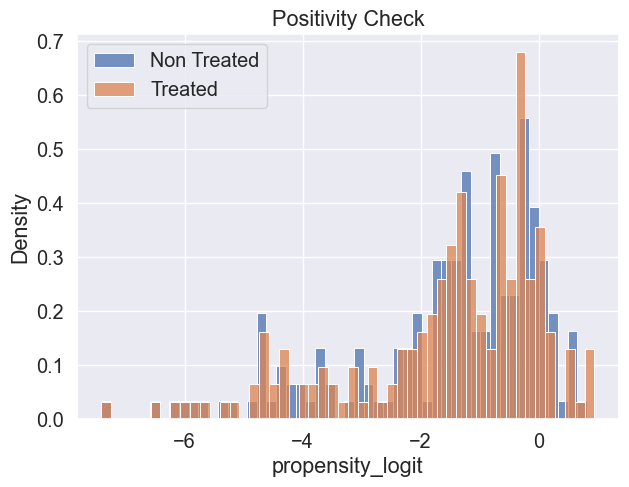

In [19]:
plt.figure(figsize=(7, 5))
sns.histplot(
    ldw_cps_trim_match.query("treat==0")["propensity_logit"],
    kde=False,
    label="Non Treated",
    bins=50,
    stat="density",
)
sns.histplot(
    ldw_cps_trim_match.query("treat==1")["propensity_logit"],
    kde=False,
    label="Treated",
    bins=50,
    stat="density",
)
plt.title("Positivity Check")
plt.legend();

### ATE

In [20]:
(
    ldw_cps_trim_match.query("treat==1")[Y].mean()
    - ldw_cps_trim_match.query("treat==0")[Y].mean()
)

np.float64(1414.9665154122022)

## Doubly Robust Estimation

In [79]:
Y = "re78"
T = "treat"
X = ldw_cps_trim_match.columns.drop([T,Y,"propensity_score","propensity_logit","row_idx","sample"])

In [80]:
doubly_robust(ldw_cps_trim_match, X, T, Y)

/Users/mi33064/Documents/AIF/Causal-Lab/causal-lab-aif/.venv-dev/causal_lab_aif-ppc9elkr-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(1327.0711790031828)

In [75]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(ldw_cps_trim_match.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [76]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (np.float64(-357.63839478051915), np.float64(2401.5098218856383))


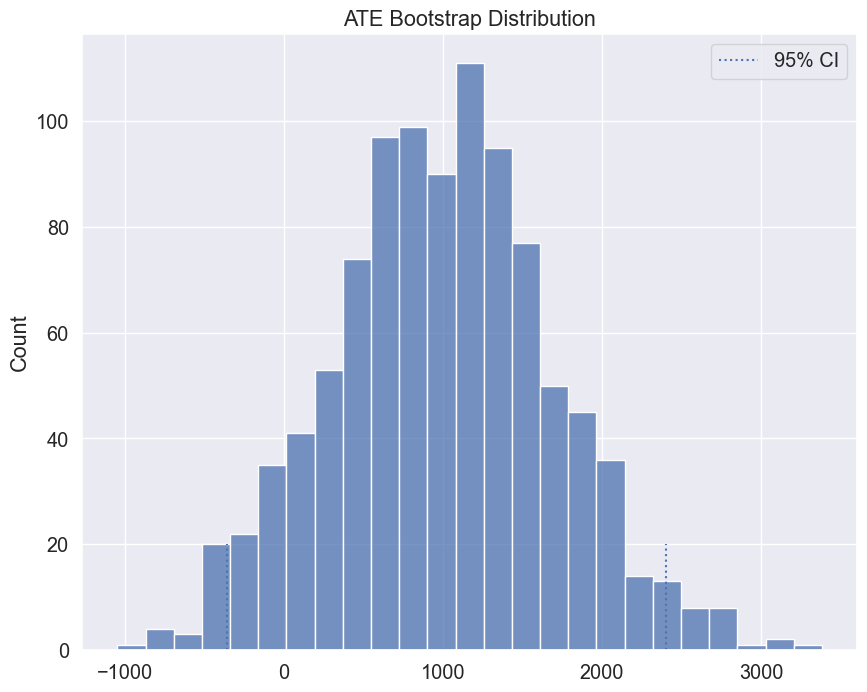

In [77]:
sns.histplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

### Covariate balance of matched sample

In [21]:
ldw_cps_trim_match[ldw_cps_trim_match[treat] == 0][covar].describe().T.drop(
    columns=["count"]
)

,mean,std,min,25%,50%,75%,max
age,25.151351,10.570612,16.0,17.0,21.00000,29.000000,55.000000
education,10.010811,2.952503,0.0,9.0,10.00000,12.000000,18.000000
black,0.837838,0.369600,0.0,1.0,1.00000,1.000000,1.000000
hispanic,0.010811,0.103692,0.0,0.0,0.00000,0.000000,1.000000
married,0.194595,0.396963,0.0,0.0,0.00000,0.000000,1.000000
nodegree,0.632432,0.483451,0.0,0.0,1.00000,1.000000,1.000000
re74,1896.347830,3847.515020,0.0,0.0,0.00000,1714.358032,25836.849609
re75,1462.974121,3256.697744,0.0,0.0,44.75806,1482.386963,25243.550781
u74,0.535135,0.500117,0.0,0.0,1.00000,1.000000,1.000000
u75,0.497297,0.501350,0.0,0.0,0.00000,1.000000,1.000000


In [22]:
ldw_cps_trim_match[ldw_cps_trim_match[treat] == 1][covar].describe().T.drop(
    columns=["count"]
)

,mean,std,min,25%,50%,75%,max
age,25.816216,7.155019,17.0,20.0,25.0,29.000000,48.000000
education,10.345946,2.010650,4.0,9.0,11.0,12.000000,16.000000
black,0.843243,0.364558,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.059459,0.237124,0.0,0.0,0.0,0.000000,1.000000
married,0.189189,0.392722,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
re74,2095.573693,4886.620354,0.0,0.0,0.0,1291.468018,35040.070312
re75,1532.055313,3219.250879,0.0,0.0,0.0,1817.284058,25142.240234
u74,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
u75,0.600000,0.491227,0.0,0.0,1.0,1.000000,1.000000


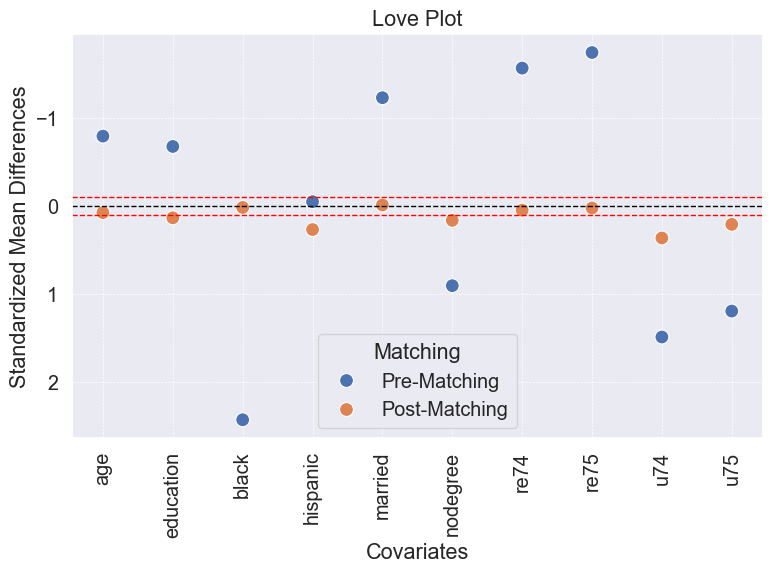

In [23]:
love_plot(raw["ldw_cps"], ldw_cps_trim_match, treat, covar)

### Appendix: Matching with Mahalanobis distance

In [24]:
X = raw["ldw_cps"].copy()

V = np.cov(X[covar].values.T)
VI = np.linalg.inv(V)

treated_grp = X[X[treat] == 1].reset_index(drop=True)
untreated_grp = X[X[treat] == 0].reset_index(drop=True)

treated_grp.reset_index(inplace=True, names="row_idx")
untreated_grp.reset_index(inplace=True, names="row_idx")

treated_grp.shape, untreated_grp.shape

((185, 15), (15992, 15))

In [25]:
%%time
results = {}

for i, row_treat in treated_grp.iterrows():
    min_dist = []
    for j, row_untreat in untreated_grp.iterrows():
        dist = mahalanobis(row_treat[covar], row_untreat[covar], VI)
        min_dist.append(dist)
    # print(f"Match for treated {i} reached at index {np.argmin(min_dist)}")
    results.update({i: np.argmin(min_dist)})

# Wall time: 23min 28s

KeyboardInterrupt: 

In [26]:
joblib.dump(results, "mahalanobis-match.pkl")

['mahalanobis-match.pkl']

In [39]:
treated_grp["match_ID"] = treated_grp["row_idx"].map(results)

In [51]:
mahalanobis_match_treated = list(results.keys())
mahalanobis_match_control = list(results.values())

mhlnb_match_t = treated_grp[untreated_grp["row_idx"].isin(mahalanobis_match_treated)]
mhlnb_match_c = untreated_grp[untreated_grp["row_idx"].isin(mahalanobis_match_control)]

mhlnb_match = pd.concat([mhlnb_match_t, mhlnb_match_c])

**Covariate balance**

In [59]:
mhlnb_match_t[covar].describe().T.drop(columns=["count"])

C:\Users\daygo\AppData\Local\Temp\ipykernel_14532\1126656064.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mhlnb_match_t = treated_grp[untreated_grp["row_idx"].isin(mahalanobis_match_treated)]


,mean,std,min,25%,50%,75%,max
age,25.816216,7.155019,17.0,20.0,25.0,29.000000,48.000000
education,10.345946,2.010650,4.0,9.0,11.0,12.000000,16.000000
black,0.843243,0.364558,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.059459,0.237124,0.0,0.0,0.0,0.000000,1.000000
married,0.189189,0.392722,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
re74,2095.573693,4886.620354,0.0,0.0,0.0,1291.468018,35040.070312
re75,1532.055313,3219.250879,0.0,0.0,0.0,1817.284058,25142.240234
u74,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
u75,0.600000,0.491227,0.0,0.0,1.0,1.000000,1.000000


In [60]:
mhlnb_match_c[covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,25.852174,9.039139,16.0,19.0,23.000000,31.000000,51.000000
education,10.478261,2.031972,3.0,9.0,11.000000,12.000000,15.000000
black,0.756522,0.431060,0.0,1.0,1.000000,1.000000,1.000000
hispanic,0.086957,0.283004,0.0,0.0,0.000000,0.000000,1.000000
married,0.234783,0.425718,0.0,0.0,0.000000,0.000000,1.000000
nodegree,0.652174,0.478365,0.0,0.0,1.000000,1.000000,1.000000
re74,3162.563184,5203.973352,0.0,0.0,0.000000,4867.798340,25113.880859
re75,2318.389945,3724.310411,0.0,0.0,449.371002,3378.338501,20488.449219
u74,0.556522,0.498969,0.0,0.0,1.000000,1.000000,1.000000
u75,0.443478,0.498969,0.0,0.0,0.000000,1.000000,1.000000


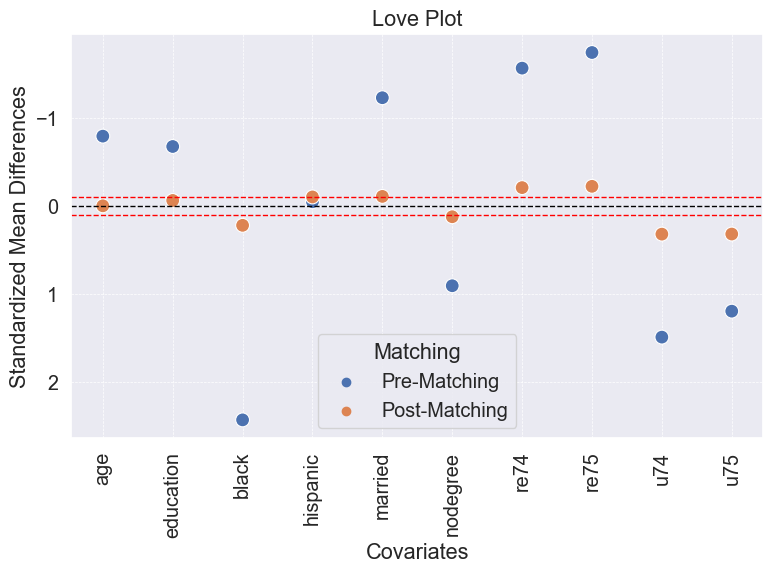

In [64]:
love_plot(raw["ldw_cps"], mhlnb_match, treat, covar)

**ATE**

In [65]:
mhlnb_match.query("treat==1")[Y].mean() - mhlnb_match.query("treat==0")[Y].mean()

1120.8184196346656